In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [2]:
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaaf

In [3]:
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [4]:
IMG_DIR = './'
JSON = 'animal.json'
KEYPOINT_DEF = pd.read_csv('keypoint_def.csv')

In [5]:
KEYPOINT_DEF

,Unnamed: 0,Index,Name,Hex colour,Stanford,Animal-pose,(name in animal pose)
0,0,0,L_eye,d82400,y,n,NaN
1,1,1,R_eye,d82400,y,n,NaN
2,2,2,L_ear,fcfc00,y,n,NaN
3,3,3,R_ear,fcfc00,y,n,NaN
4,4,4,Nose,d848ff,y,n,NaN
5,5,5,Throat,fc90aa,y,n,NaN
6,6,6,Tail,48b455,y,n,NaN
7,7,7,withers,48b455,y,n,NaN
8,8,8,L_F_elbow,0090aa,y,n,NaN
9,9,9,R_F_elbow,0090aa,y,n,NaN


In [6]:
with open(JSON) as infile:
    json_dict = json.load(infile)

In [7]:
json_dict

{'img/379.jpeg': {'img_bbox': [63, 0, 131, 222],
  'img_width': 300,
  'img_height': 225,
  'img_path': 'img/379.jpeg',
  'joints': [[144, 66, 1],
   [108, 65, 1],
   [158, 23, 1],
   [88, 27, 1],
   [124, 91, 1],
   [122, 121, 1],
   [0, 0, 0],
   [0, 0, 0],
   [154, 131, 1],
   [105, 129, 1],
   [0, 0, 0],
   [0, 0, 0],
   [141, 140, 1],
   [92, 141, 1],
   [0, 0, 0],
   [0, 0, 0],
   [121, 151, 1],
   [77, 157, 1],
   [0, 0, 0],
   [0, 0, 0]]},
 'img/380.jpeg': {'img_bbox': [47, 10, 212, 178],
  'img_width': 300,
  'img_height': 200,
  'img_path': 'img/380.jpeg',
  'joints': [[0, 0, 0],
   [232, 40, 1],
   [219, 21, 1],
   [213, 25, 1],
   [256, 49, 1],
   [218, 79, 1],
   [77, 109, 1],
   [167, 67, 1],
   [0, 0, 0],
   [184, 121, 1],
   [118, 136, 1],
   [97, 134, 1],
   [195, 155, 1],
   [186, 169, 1],
   [85, 171, 1],
   [53, 164, 1],
   [0, 0, 0],
   [196, 183, 1],
   [0, 0, 0],
   [0, 0, 0]]},
 'img/381.jpeg': {'img_bbox': [99, 14, 196, 168],
  'img_width': 300,
  'img_height':

In [8]:
colours = KEYPOINT_DEF["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = KEYPOINT_DEF["Name"].values.tolist()

In [9]:
def get_dog(name):
    data = json_dict[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

In [10]:
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()

In [11]:
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

In [12]:
for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]
    images.append(image)
    keypoints.append(keypoint)

In [13]:
keypoints

[[[40, 43, 1],
  [0, 0, 0],
  [60, 33, 1],
  [0, 0, 0],
  [20, 55, 1],
  [57, 85, 1],
  [214, 105, 1],
  [97, 78, 1],
  [69, 152, 1],
  [0, 0, 0],
  [192, 171, 1],
  [0, 0, 0],
  [75, 200, 1],
  [84, 193, 1],
  [221, 210, 1],
  [220, 189, 1],
  [67, 222, 1],
  [0, 0, 0],
  [214, 242, 1],
  [202, 211, 1]],
 [[149, 27, 1],
  [124, 25, 1],
  [176, 27, 1],
  [114, 21, 1],
  [128, 39, 1],
  [149, 92, 1],
  [74, 111, 1],
  [0, 0, 0],
  [182, 141, 1],
  [129, 132, 1],
  [0, 0, 0],
  [77, 146, 1],
  [180, 180, 1],
  [127, 181, 1],
  [0, 0, 0],
  [75, 181, 1],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0],
  [0, 0, 0]],
 [[93, 79, 1],
  [0, 0, 0],
  [104, 79, 1],
  [116, 75, 1],
  [71, 85, 1],
  [110, 118, 1],
  [247, 137, 1],
  [146, 103, 1],
  [155, 156, 1],
  [0, 0, 0],
  [226, 179, 1],
  [210, 179, 1],
  [150, 191, 1],
  [138, 191, 1],
  [260, 196, 1],
  [228, 203, 1],
  [144, 208, 1],
  [130, 206, 1],
  [257, 212, 1],
  [213, 212, 1]],
 [[140, 41, 1],
  [115, 41, 1],
  [166, 28, 1],
  [108, 25, 1]

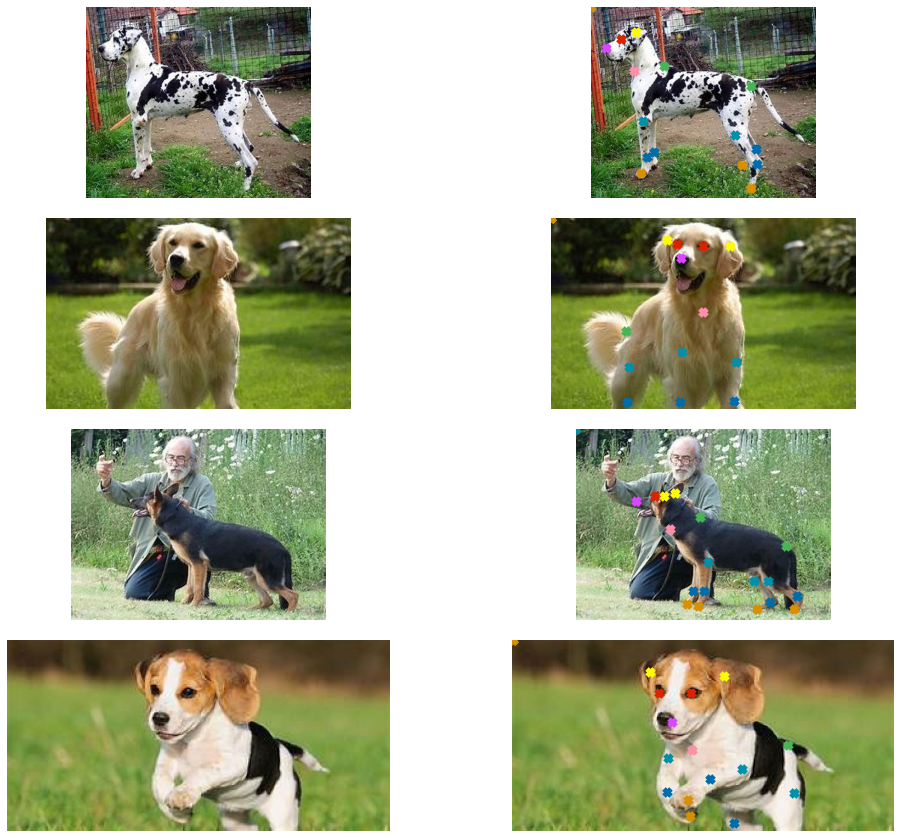

In [14]:
visualize_keypoints(images, keypoints)